In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
import copy
from tqdm.notebook import tqdm
from numba import jit
from scipy import stats
import networkx as nx
import re

import matplotlib.lines as mlines
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


import warnings
warnings.filterwarnings('ignore')
plt.style.use("../config/custom_plt.mplstyle")

In [2]:
def generate_random_positions(N):
    return np.random.uniform(0, 2*np.pi, size=N)


def angle(t1, t2):
    return np.pi - np.fabs(np.pi - np.fabs(t1 - t2))


def assign_labels(thetas, centers, alpha):
    labels = []
    for t in thetas:
        total_distance = sum([np.power(angle(t, c), -alpha) for c in centers]) 
        prob = [np.power(angle(t, c), -alpha) / total_distance for c in centers]
        l = np.random.choice(len(prob), size=1, p=prob)[0]
        labels.append(l)
    return labels

In [88]:
ntimes = 100
N = 1000
nlabels = [2, 3, 6, 10]
alphas = np.arange(-10, 11)

res = {}

for l in tqdm(nlabels):
    for a in tqdm(alphas):
        mean_distance = []
        for i in range(ntimes): 
            thetas = generate_random_positions(N)
            centers = generate_random_positions(l)
            labels = assign_labels(thetas, centers, a)

            tmp = pd.DataFrame([(x, y) for x,y in zip(thetas, labels)])
            tmp.columns = ['theta', 'label']
            
            #tmp = tmp.groupby('label').mean().reset_index()
            #tmp['centers'] = centers
            #distance = np.mean(angle(tmp['theta'].values, tmp['centers'].values))
            
            # Maximum distance between nodes inside one community
            max_distances = []
            for name, group in tmp.groupby('label'):
                all_thetas = group['theta']
                max_distance = 0
                for t1 in all_thetas:
                    for t2 in all_thetas:
                        d = angle(t1, t2)
                        if d > max_distance:
                            max_distance = d
    
                max_distances.append(max_distance)
                
            distance = np.mean(max_distances)
            mean_distance.append(distance)

        res[(l, a)] = (np.mean(mean_distance), np.std(mean_distance))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [89]:
df = pd.DataFrame(res).T.reset_index()
df.columns = ['nlabels', 'alpha', 'distance', 'distance_std']
df.head()

,nlabels,alpha,distance,distance_std
0,2,-10,3.141362,0.000226
1,2,-9,3.141427,0.000165
2,2,-8,3.141422,0.000126
3,2,-7,3.141458,0.000106
4,2,-6,3.141471,0.000104


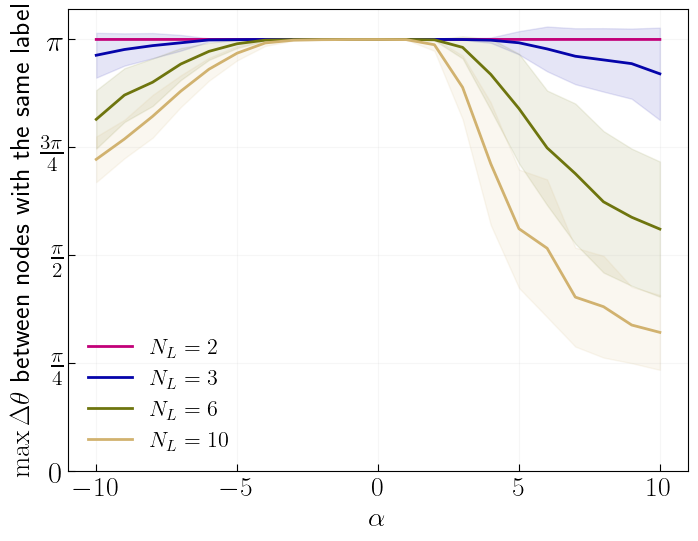

In [96]:
i = 0
colors = ['xkcd:magenta', 'xkcd:royal blue', 'xkcd:olive', 'xkcd:tan']

for name, group in df.groupby('nlabels'):
    plt.plot(group['alpha'], group['distance'], color=colors[i], label=rf'$N_L={{{name}}}$')
    plt.fill_between(group['alpha'], group['distance']+group['distance_std'], 
                     group['distance']-group['distance_std'], color=colors[i], alpha=0.1)
    i += 1
    
# plt.axhline(np.pi/2, color='black', linestyle='--')
plt.yticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], 
           ['$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'], fontsize=22)
plt.xticks([-10, -5, 0, 5, 10], [f'${{{x}}}$' for x in [-10, -5, 0, 5, 10]], fontsize=20)
plt.legend()
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\max \Delta\theta$ between nodes with the same label')
